In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("../..")
%matplotlib inline

In [2]:
from processor.preprocessors import data_split
from trading_env.env_cryptotrading_v1 import CryptoTradingEnv
from agent.models import DRLAgent
from config import (
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    VALID_2_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
)
from stable_baselines3.common.logger import configure

In [3]:
processed_dts10_add_tech = pd.read_csv("../../dataset/daily-level/crypto_TI_t10_2023-04-01.csv")

In [4]:
state_interval = 5
TEST_START_DATE = pd.to_datetime(TEST_START_DATE)
TEST_START_DATE = TEST_START_DATE - pd.Timedelta(days=state_interval - 1)
TEST_START_DATE = TEST_START_DATE.strftime('%Y-%m-%d')

In [5]:
train = data_split(processed_dts10_add_tech, TRAIN_START_DATE, VALID_2_END_DATE)
valid = data_split(processed_dts10_add_tech, TEST_START_DATE, TEST_END_DATE)

print(len(train))
print(len(valid))


7290
940


In [6]:
crypto_tic_dim = len(train.tic.unique())
# state_space_dim = 1 + 2*crypto_tic_dim + len(INDICATORS)*crypto_tic_dim
state_space_dim = 1 + (state_interval * 5 + 1) * crypto_tic_dim
print(f"Stock Dimension: {crypto_tic_dim}, State Space: {state_space_dim}")

Stock Dimension: 10, State Space: 261


## Agents

### PPO

In [7]:
buy_cost_list = sell_cost_list = [0.001] * crypto_tic_dim
num_stock_shares = [0] * crypto_tic_dim

env_kwargs_train = {
    "cash": 100000,
    "action_scaling": 1/10,
    "num_crypto_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space_dim": state_space_dim,
    "crypto_dim": crypto_tic_dim,
    "action_space_dim": crypto_tic_dim,
    "print_verbosity": 50,
    "eval_time_interval": 30,
    "is_debug": False,
    "risk_control": False,
    "model_name": "ppo_daily_level_pnl_reward_stack_5",
    "data_granularity": 1,
    "state_interval": state_interval
}
env_kwargs_test = env_kwargs_train.copy()
env_kwargs_test["is_debug"] = False

In [8]:
e_train_gym = CryptoTradingEnv(df = train, **env_kwargs_train)
e_valid_gym = CryptoTradingEnv(df = valid, **env_kwargs_test)

In [9]:
agent = DRLAgent(env = e_train_gym)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.001,
    "batch_size": 256
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS, seed=42)
# set up logger
tmp_path = RESULTS_DIR + '/ppo_daily_level_pnl_reward_stack_5'
new_logger_ppo = configure(tmp_path, ["csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.001, 'batch_size': 256}
Using cuda device


In [10]:
final = []
iterations = 30
max_account_value = 0

for i in range(iterations):
    # train model
    trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=100000)
    df_account_value_ppo, df_actionppo, df_valid_actionppo, df_stateppo = DRLAgent.DRL_prediction(model=trained_ppo, environment=e_valid_gym)
    res = df_account_value_ppo["portfolio_value"][len(df_account_value_ppo)-1]
    final.append(df_account_value_ppo["portfolio_value"])
    df_account_value_ppo.to_csv(f"../../plot/dataset/ppo_daily_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_pnl_reward.csv")
    trained_ppo.save(f"../../model_saves/ppo_daily_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_pnl_reward")


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 50
begin_portfolio_value:	 99953.75
end_portfolio_value:	 130254.23
total_profits:		 30300.49
total_buy_cost:		 32448.94
total_sell_cost:	 32429.51
total_buy_trades:	 1631
total_sell_trades:	 2044

episode:		 100
begin_portfolio_value:	 99978.32
end_portfolio_value:	 99263.38
total_profits:		 -714.94
total_buy_cost:		 21567.24
total_sell_cost:	 21510.32
total_buy_trades:	 1403
total_sell_trades:	 1754

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 150
begin_portfolio_value:	 99967.51
end_portfolio_value:	 381468.30
total_profits:		 281500.79
total_buy_cost:		 57145.23
total_sell_cost:	 57159.54
total_buy_trades:	 1598
total_sell_trades:	 1926

episode:		 200
begin_portfolio_value:	 99963.06
end_portfolio_value:	 306933.06
total_profits:		 206970.00
total_buy_cost:		 73748.84
total_sell_cost:	 73796.38
total_buy_trades:	 1730
total_sell_trades:	 2048

episode:		 250
begin_portfolio_value:	 99964.48
end_portfolio_value:	 106560.78
total_profits:		 6596.31
total_buy_cost:		 35787.99
total_sell_cost:	 35759.54
total_buy_trades:	 1612
total_sell_trades:	 1926

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 300
begin_portfolio_value:	 99979.68
end_portfolio_value:	 250255.05
total_profits:		 150275.38
total_buy_cost:		 42766.23
total_sell_cost:	 42751.75
total_buy_trades:	 1306
total_sell_trades:	 1565

episode:		 350
begin_portfolio_value:	 99957.08
end_portfolio_value:	 195958.36
total_profits:		 96001.29
total_buy_cost:		 47336.62
total_sell_cost:	 47331.28
total_buy_trades:	 1459
total_sell_trades:	 1718

episode:		 400
begin_portfolio_value:	 99963.09
end_portfolio_value:	 456843.44
total_profits:		 356880.36
total_buy_cost:		 75612.69
total_sell_cost:	 75663.97
total_buy_trades:	 1509
total_sell_trades:	 1775

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 450
begin_portfolio_value:	 99940.06
end_portfolio_value:	 202385.38
total_profits:		 102445.32
total_buy_cost:		 45331.82
total_sell_cost:	 45322.48
total_buy_trades:	 1383
total_sell_trades:	 1620

episode:		 500
begin_portfolio_value:	 99942.80
end_portfolio_value:	 308192.79
total_profits:		 208249.99
total_buy_cost:		 49277.97
total_sell_cost:	 49276.52
total_buy_trades:	 1459
total_sell_trades:	 1674

episode:		 550
begin_portfolio_value:	 99967.46
end_portfolio_value:	 156535.10
total_profits:		 56567.64
total_buy_cost:		 38098.91
total_sell_cost:	 38075.08
total_buy_trades:	 1449
total_sell_trades:	 1646

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 600
begin_portfolio_value:	 99959.11
end_portfolio_value:	 67429.30
total_profits:		 -32529.81
total_buy_cost:		 20363.86
total_sell_cost:	 20304.52
total_buy_trades:	 1418
total_sell_trades:	 1613

episode:		 650
begin_portfolio_value:	 99954.51
end_portfolio_value:	 132506.37
total_profits:		 32551.86
total_buy_cost:		 39534.16
total_sell_cost:	 39513.21
total_buy_trades:	 1454
total_sell_trades:	 1630

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 700
begin_portfolio_value:	 99937.37
end_portfolio_value:	 208353.42
total_profits:		 108416.05
total_buy_cost:		 38838.14
total_sell_cost:	 38815.79
total_buy_trades:	 1396
total_sell_trades:	 1546

episode:		 750
begin_portfolio_value:	 99948.27
end_portfolio_value:	 91544.35
total_profits:		 -8403.92
total_buy_cost:		 25851.54
total_sell_cost:	 25803.19
total_buy_trades:	 1488
total_sell_trades:	 1666

episode:		 800
begin_portfolio_value:	 99961.85
end_portfolio_value:	 169577.18
total_profits:		 69615.34
total_buy_cost:		 35481.69
total_sell_cost:	 35452.63
total_buy_trades:	 1343
total_sell_trades:	 1488

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 850
begin_portfolio_value:	 99954.50
end_portfolio_value:	 389915.31
total_profits:		 289960.81
total_buy_cost:		 77208.86
total_sell_cost:	 77263.33
total_buy_trades:	 1443
total_sell_trades:	 1597

episode:		 900
begin_portfolio_value:	 99960.51
end_portfolio_value:	 264295.29
total_profits:		 164334.78
total_buy_cost:		 57431.77
total_sell_cost:	 57446.65
total_buy_trades:	 1534
total_sell_trades:	 1707

episode:		 950
begin_portfolio_value:	 99950.05
end_portfolio_value:	 151214.59
total_profits:		 51264.54
total_buy_cost:		 37837.15
total_sell_cost:	 37812.80
total_buy_trades:	 1400
total_sell_trades:	 1530

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1000
begin_portfolio_value:	 99952.18
end_portfolio_value:	 262067.37
total_profits:		 162115.19
total_buy_cost:		 56637.47
total_sell_cost:	 56650.76
total_buy_trades:	 1416
total_sell_trades:	 1559

episode:		 1050
begin_portfolio_value:	 99966.43
end_portfolio_value:	 85673.00
total_profits:		 -14293.43
total_buy_cost:		 27076.02
total_sell_cost:	 27030.13
total_buy_trades:	 1209
total_sell_trades:	 1312

episode:		 1100
begin_portfolio_value:	 99970.03
end_portfolio_value:	 117556.75
total_profits:		 17586.72
total_buy_cost:		 21939.49
total_sell_cost:	 21883.31
total_buy_trades:	 1173
total_sell_trades:	 1256

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1150
begin_portfolio_value:	 99934.58
end_portfolio_value:	 96877.50
total_profits:		 -3057.08
total_buy_cost:		 19308.82
total_sell_cost:	 19247.38
total_buy_trades:	 1099
total_sell_trades:	 1175

episode:		 1200
begin_portfolio_value:	 99970.03
end_portfolio_value:	 165735.85
total_profits:		 65765.82
total_buy_cost:		 46609.20
total_sell_cost:	 46602.41
total_buy_trades:	 1507
total_sell_trades:	 1627

episode:		 1250
begin_portfolio_value:	 99970.03
end_portfolio_value:	 85610.99
total_profits:		 -14359.04
total_buy_cost:		 24694.81
total_sell_cost:	 24644.15
total_buy_trades:	 1422
total_sell_trades:	 1553

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1300
begin_portfolio_value:	 99930.07
end_portfolio_value:	 110409.67
total_profits:		 10479.60
total_buy_cost:		 39991.55
total_sell_cost:	 39971.52
total_buy_trades:	 1499
total_sell_trades:	 1638

episode:		 1350
begin_portfolio_value:	 99950.05
end_portfolio_value:	 286394.57
total_profits:		 186444.52
total_buy_cost:		 61125.56
total_sell_cost:	 61147.83
total_buy_trades:	 1544
total_sell_trades:	 1686

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1400
begin_portfolio_value:	 99940.84
end_portfolio_value:	 159687.46
total_profits:		 59746.61
total_buy_cost:		 45274.76
total_sell_cost:	 45265.30
total_buy_trades:	 1714
total_sell_trades:	 1878

episode:		 1450
begin_portfolio_value:	 99948.57
end_portfolio_value:	 229527.66
total_profits:		 129579.10
total_buy_cost:		 79565.16
total_sell_cost:	 79624.35
total_buy_trades:	 1715
total_sell_trades:	 1873

episode:		 1500
begin_portfolio_value:	 99948.83
end_portfolio_value:	 128463.02
total_profits:		 28514.19
total_buy_cost:		 59160.19
total_sell_cost:	 59178.53
total_buy_trades:	 1877
total_sell_trades:	 2047

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1550
begin_portfolio_value:	 99940.06
end_portfolio_value:	 132441.86
total_profits:		 32501.80
total_buy_cost:		 36536.84
total_sell_cost:	 36509.89
total_buy_trades:	 1740
total_sell_trades:	 1890

episode:		 1600
begin_portfolio_value:	 99967.00
end_portfolio_value:	 102565.63
total_profits:		 2598.63
total_buy_cost:		 69304.68
total_sell_cost:	 69343.33
total_buy_trades:	 1916
total_sell_trades:	 2085

episode:		 1650
begin_portfolio_value:	 99960.04
end_portfolio_value:	 162667.20
total_profits:		 62707.16
total_buy_cost:		 49884.60
total_sell_cost:	 49884.37
total_buy_trades:	 1816
total_sell_trades:	 1971

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1700
begin_portfolio_value:	 99930.07
end_portfolio_value:	 106138.47
total_profits:		 6208.40
total_buy_cost:		 51867.91
total_sell_cost:	 51871.65
total_buy_trades:	 1743
total_sell_trades:	 1890

episode:		 1750
begin_portfolio_value:	 99930.07
end_portfolio_value:	 368220.60
total_profits:		 268290.53
total_buy_cost:		 121161.32
total_sell_cost:	 121303.79
total_buy_trades:	 1791
total_sell_trades:	 1935

episode:		 1800
begin_portfolio_value:	 99950.05
end_portfolio_value:	 206498.17
total_profits:		 106548.12
total_buy_cost:		 55800.87
total_sell_cost:	 55812.48
total_buy_trades:	 1833
total_sell_trades:	 1974

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1850
begin_portfolio_value:	 99941.99
end_portfolio_value:	 215231.91
total_profits:		 115289.91
total_buy_cost:		 69591.97
total_sell_cost:	 69631.19
total_buy_trades:	 1713
total_sell_trades:	 1849

episode:		 1900
begin_portfolio_value:	 99940.06
end_portfolio_value:	 172746.34
total_profits:		 72806.28
total_buy_cost:		 68751.52
total_sell_cost:	 68789.06
total_buy_trades:	 1823
total_sell_trades:	 1973

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1950
begin_portfolio_value:	 99950.05
end_portfolio_value:	 195560.47
total_profits:		 95610.42
total_buy_cost:		 41093.69
total_sell_cost:	 41075.86
total_buy_trades:	 1720
total_sell_trades:	 1856

episode:		 2000
begin_portfolio_value:	 99960.04
end_portfolio_value:	 182447.06
total_profits:		 82487.02
total_buy_cost:		 47010.91
total_sell_cost:	 47004.93
total_buy_trades:	 1746
total_sell_trades:	 1881

episode:		 2050
begin_portfolio_value:	 99940.06
end_portfolio_value:	 83444.23
total_profits:		 -16495.83
total_buy_cost:		 34673.07
total_sell_cost:	 34643.40
total_buy_trades:	 1615
total_sell_trades:	 1729

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2100
begin_portfolio_value:	 99965.38
end_portfolio_value:	 193102.93
total_profits:		 93137.55
total_buy_cost:		 49083.20
total_sell_cost:	 49081.36
total_buy_trades:	 1759
total_sell_trades:	 1873

episode:		 2150
begin_portfolio_value:	 99970.03
end_portfolio_value:	 237536.58
total_profits:		 137566.55
total_buy_cost:		 90055.58
total_sell_cost:	 90135.78
total_buy_trades:	 1825
total_sell_trades:	 1957

episode:		 2200
begin_portfolio_value:	 99960.04
end_portfolio_value:	 142023.12
total_profits:		 42063.08
total_buy_cost:		 47227.82
total_sell_cost:	 47222.27
total_buy_trades:	 1859
total_sell_trades:	 2000

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2250
begin_portfolio_value:	 99930.07
end_portfolio_value:	 78982.03
total_profits:		 -20948.04
total_buy_cost:		 30739.93
total_sell_cost:	 30707.47
total_buy_trades:	 1791
total_sell_trades:	 1925

episode:		 2300
begin_portfolio_value:	 99940.06
end_portfolio_value:	 186428.35
total_profits:		 86488.29
total_buy_cost:		 58228.08
total_sell_cost:	 58244.56
total_buy_trades:	 1747
total_sell_trades:	 1858

episode:		 2350
begin_portfolio_value:	 99940.06
end_portfolio_value:	 104972.00
total_profits:		 5031.94
total_buy_cost:		 38985.08
total_sell_cost:	 38963.03
total_buy_trades:	 1735
total_sell_trades:	 1867

episode:		 50
begin_portfolio_value:	 99940.06
end_portfolio_value:	 138198.70
total_profits:		 38258.64
total_buy_cost:		 415.00
total_sell_cost:	 315.73
total_buy_trades:	 51
total_sell_trades:	 42

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2400
begin_portfolio_value:	 99970.03
end_portfolio_value:	 249153.82
total_profits:		 149183.79
total_buy_cost:		 63862.32
total_sell_cost:	 63890.08
total_buy_trades:	 1629
total_sell_trades:	 1716

episode:		 2450
begin_portfolio_value:	 99949.65
end_portfolio_value:	 276581.07
total_profits:		 176631.41
total_buy_cost:		 68525.35
total_sell_cost:	 68562.44
total_buy_trades:	 1769
total_sell_trades:	 1869

episode:		 2500
begin_portfolio_value:	 99940.06
end_portfolio_value:	 230625.05
total_profits:		 130684.99
total_buy_cost:		 44994.31
total_sell_cost:	 44984.29
total_buy_trades:	 1628
total_sell_trades:	 1734

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2550
begin_portfolio_value:	 99932.65
end_portfolio_value:	 193826.90
total_profits:		 93894.25
total_buy_cost:		 44265.98
total_sell_cost:	 44254.50
total_buy_trades:	 1421
total_sell_trades:	 1498

episode:		 2600
begin_portfolio_value:	 99940.06
end_portfolio_value:	 138264.04
total_profits:		 38323.98
total_buy_cost:		 45264.20
total_sell_cost:	 45254.72
total_buy_trades:	 1651
total_sell_trades:	 1768

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2650
begin_portfolio_value:	 99960.04
end_portfolio_value:	 77946.47
total_profits:		 -22013.57
total_buy_cost:		 31307.96
total_sell_cost:	 31270.54
total_buy_trades:	 1648
total_sell_trades:	 1753

episode:		 2700
begin_portfolio_value:	 99920.08
end_portfolio_value:	 392434.61
total_profits:		 292514.53
total_buy_cost:		 71006.98
total_sell_cost:	 71049.04
total_buy_trades:	 1612
total_sell_trades:	 1721

episode:		 2750
begin_portfolio_value:	 99970.03
end_portfolio_value:	 100519.50
total_profits:		 549.47
total_buy_cost:		 27445.96
total_sell_cost:	 27400.81
total_buy_trades:	 1534
total_sell_trades:	 1637

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2800
begin_portfolio_value:	 99930.07
end_portfolio_value:	 116197.53
total_profits:		 16267.46
total_buy_cost:		 45894.97
total_sell_cost:	 45886.75
total_buy_trades:	 1689
total_sell_trades:	 1790

episode:		 2850
begin_portfolio_value:	 99970.03
end_portfolio_value:	 189665.49
total_profits:		 89695.46
total_buy_cost:		 56502.90
total_sell_cost:	 56515.92
total_buy_trades:	 1818
total_sell_trades:	 1924

episode:		 2900
begin_portfolio_value:	 99960.04
end_portfolio_value:	 81036.22
total_profits:		 -18923.82
total_buy_cost:		 29870.89
total_sell_cost:	 29830.59
total_buy_trades:	 1642
total_sell_trades:	 1746

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2950
begin_portfolio_value:	 99960.04
end_portfolio_value:	 316178.95
total_profits:		 216218.91
total_buy_cost:		 81956.26
total_sell_cost:	 82020.24
total_buy_trades:	 1730
total_sell_trades:	 1856

episode:		 3000
begin_portfolio_value:	 99960.04
end_portfolio_value:	 111359.88
total_profits:		 11399.84
total_buy_cost:		 36968.89
total_sell_cost:	 36942.80
total_buy_trades:	 1591
total_sell_trades:	 1691

episode:		 3050
begin_portfolio_value:	 99960.04
end_portfolio_value:	 108302.74
total_profits:		 8342.70
total_buy_cost:		 43071.75
total_sell_cost:	 43057.88
total_buy_trades:	 1538
total_sell_trades:	 1633

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3100
begin_portfolio_value:	 99960.04
end_portfolio_value:	 193731.29
total_profits:		 93771.25
total_buy_cost:		 65899.15
total_sell_cost:	 65930.98
total_buy_trades:	 1766
total_sell_trades:	 1874

episode:		 3150
begin_portfolio_value:	 99940.06
end_portfolio_value:	 228647.42
total_profits:		 128707.36
total_buy_cost:		 75439.17
total_sell_cost:	 75513.77
total_buy_trades:	 1756
total_sell_trades:	 1882

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3200
begin_portfolio_value:	 99940.06
end_portfolio_value:	 138261.41
total_profits:		 38321.35
total_buy_cost:		 45551.73
total_sell_cost:	 45542.82
total_buy_trades:	 1632
total_sell_trades:	 1712

episode:		 3250
begin_portfolio_value:	 99960.04
end_portfolio_value:	 460651.50
total_profits:		 360691.46
total_buy_cost:		 121788.57
total_sell_cost:	 121932.29
total_buy_trades:	 1732
total_sell_trades:	 1849

episode:		 3300
begin_portfolio_value:	 99950.05
end_portfolio_value:	 188260.55
total_profits:		 88310.50
total_buy_cost:		 58264.96
total_sell_cost:	 58281.51
total_buy_trades:	 1752
total_sell_trades:	 1844

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3350
begin_portfolio_value:	 99970.03
end_portfolio_value:	 102528.50
total_profits:		 2558.47
total_buy_cost:		 33064.56
total_sell_cost:	 33030.65
total_buy_trades:	 1588
total_sell_trades:	 1673

episode:		 3400
begin_portfolio_value:	 99960.04
end_portfolio_value:	 379340.86
total_profits:		 279380.82
total_buy_cost:		 88745.94
total_sell_cost:	 88823.50
total_buy_trades:	 1707
total_sell_trades:	 1804

episode:		 3450
begin_portfolio_value:	 99950.05
end_portfolio_value:	 237440.17
total_profits:		 137490.12
total_buy_cost:		 78908.27
total_sell_cost:	 79009.02
total_buy_trades:	 1809
total_sell_trades:	 1935

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3500
begin_portfolio_value:	 99940.06
end_portfolio_value:	 280140.51
total_profits:		 180200.45
total_buy_cost:		 74367.85
total_sell_cost:	 74416.63
total_buy_trades:	 1699
total_sell_trades:	 1790

episode:		 3550
begin_portfolio_value:	 99940.06
end_portfolio_value:	 202457.67
total_profits:		 102517.61
total_buy_cost:		 78999.07
total_sell_cost:	 79057.13
total_buy_trades:	 1637
total_sell_trades:	 1744

episode:		 3600
begin_portfolio_value:	 99950.05
end_portfolio_value:	 210824.60
total_profits:		 110874.55
total_buy_cost:		 50841.88
total_sell_cost:	 50843.56
total_buy_trades:	 1711
total_sell_trades:	 1818

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3650
begin_portfolio_value:	 99970.03
end_portfolio_value:	 250322.70
total_profits:		 150352.67
total_buy_cost:		 61805.29
total_sell_cost:	 61828.93
total_buy_trades:	 1612
total_sell_trades:	 1701

episode:		 3700
begin_portfolio_value:	 99950.05
end_portfolio_value:	 187952.93
total_profits:		 88002.88
total_buy_cost:		 55881.06
total_sell_cost:	 55934.30
total_buy_trades:	 1600
total_sell_trades:	 1710

episode:		 3750
begin_portfolio_value:	 99930.07
end_portfolio_value:	 312126.78
total_profits:		 212196.71
total_buy_cost:		 73820.82
total_sell_cost:	 73868.51
total_buy_trades:	 1579
total_sell_trades:	 1662

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3800
begin_portfolio_value:	 99970.03
end_portfolio_value:	 103583.16
total_profits:		 3613.13
total_buy_cost:		 39495.88
total_sell_cost:	 39474.86
total_buy_trades:	 1776
total_sell_trades:	 1903

episode:		 3850
begin_portfolio_value:	 99940.06
end_portfolio_value:	 262642.85
total_profits:		 162702.79
total_buy_cost:		 81982.71
total_sell_cost:	 82046.74
total_buy_trades:	 1809
total_sell_trades:	 1927

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3900
begin_portfolio_value:	 99940.06
end_portfolio_value:	 124696.49
total_profits:		 24756.43
total_buy_cost:		 39332.19
total_sell_cost:	 39335.88
total_buy_trades:	 1803
total_sell_trades:	 1898

episode:		 3950
begin_portfolio_value:	 99920.08
end_portfolio_value:	 188098.13
total_profits:		 88178.05
total_buy_cost:		 50784.77
total_sell_cost:	 50786.34
total_buy_trades:	 1666
total_sell_trades:	 1768

episode:		 4000
begin_portfolio_value:	 99960.04
end_portfolio_value:	 138289.78
total_profits:		 38329.74
total_buy_cost:		 53517.54
total_sell_cost:	 53524.59
total_buy_trades:	 1679
total_sell_trades:	 1782

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 4050
begin_portfolio_value:	 99960.04
end_portfolio_value:	 255100.50
total_profits:		 155140.46
total_buy_cost:		 67943.74
total_sell_cost:	 67979.66
total_buy_trades:	 1600
total_sell_trades:	 1698

episode:		 4100
begin_portfolio_value:	 99970.03
end_portfolio_value:	 559703.52
total_profits:		 459733.49
total_buy_cost:		 133636.22
total_sell_cost:	 133803.66
total_buy_trades:	 1647
total_sell_trades:	 1747

episode:		 4150
begin_portfolio_value:	 99940.06
end_portfolio_value:	 87914.91
total_profits:		 -12025.15
total_buy_cost:		 39020.74
total_sell_cost:	 38998.76
total_buy_trades:	 1684
total_sell_trades:	 1767

hit end!


# Backtesting results

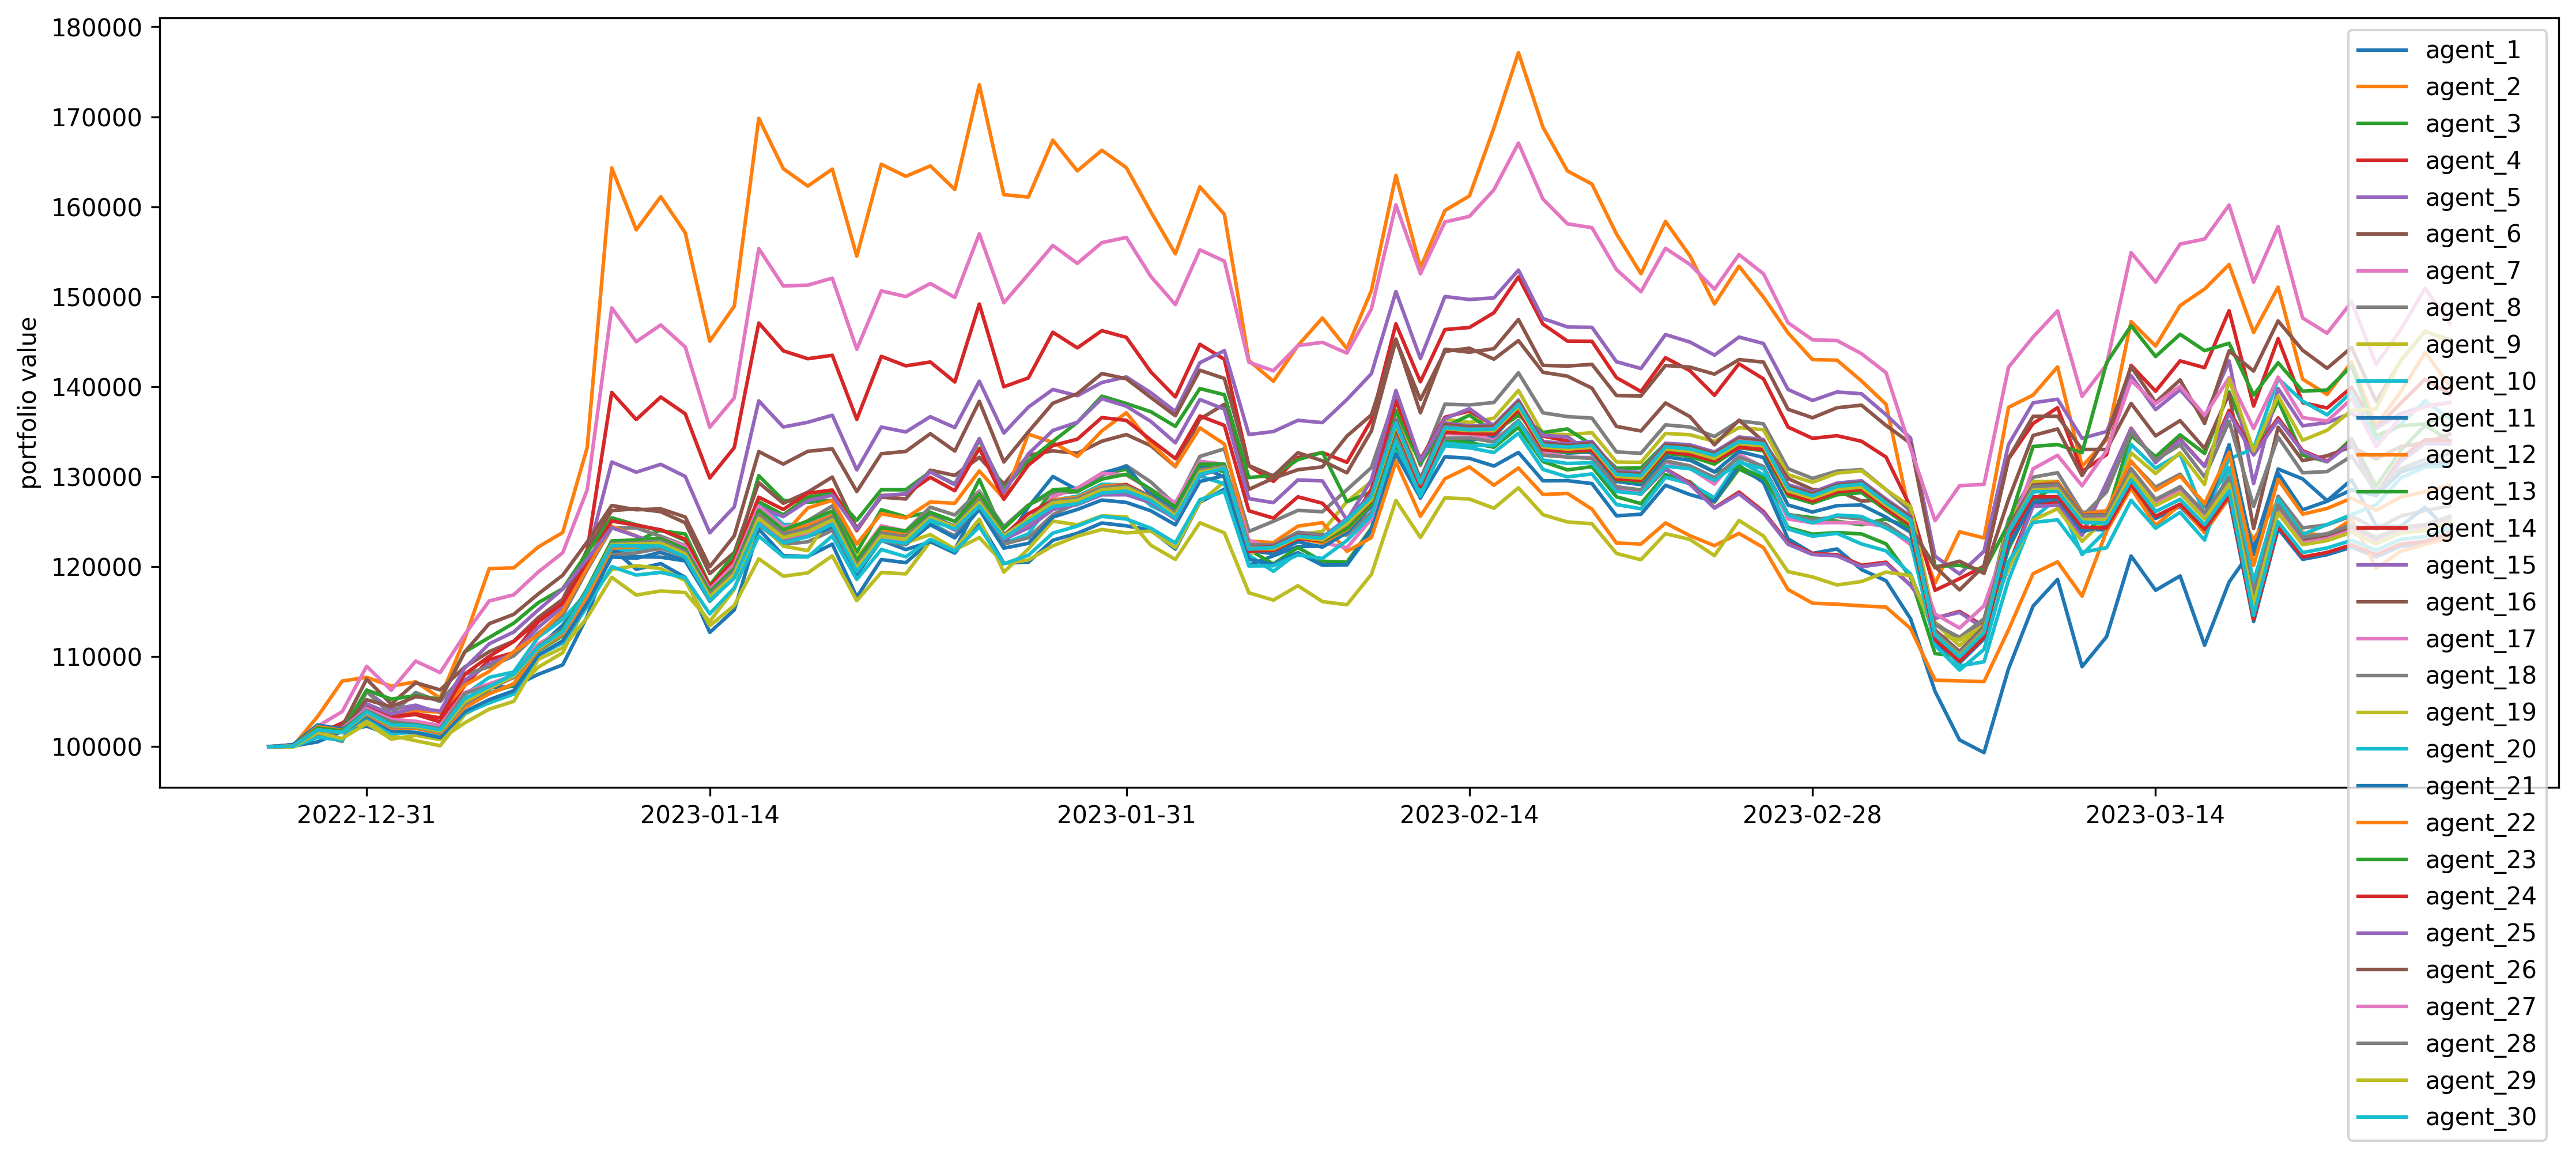

In [11]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["figure.dpi"] = 300
plt.figure()

x = df_account_value_ppo["timestamp"]
x = pd.to_datetime(x)
s = 1
for i in final:
    plt.plot(x,i,label=f'agent_{s}')
    s+=1
plt.ylabel("portfolio value")
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig("../../plot/test_plot/ppo_daily_stack_frame/stack_5_test_default_ppo_act_0.1_seed_42_pnl_reward.png", dpi=300)
plt.show()

In [12]:
df = pd.DataFrame(data = x)
s = 1
for i in final:
    df[f"round_{s}"] = i
    s += 1
df.to_csv("stack_5_test_default_ppo_act_0.1_seed_42_pnl_reward.csv")